In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
%matplotlib inline

In [51]:
DATA_DIR = '/content/gdrive/My Drive/Colab Notebooks/dl-sp-c1w4/datasets'

def reshape_input(x):
    return x

def load_data():
    import h5py
    import numpy as np
    import os

    train_path = f"{DATA_DIR}/train_catvnoncat.h5"
    test_path = f"{DATA_DIR}/test_catvnoncat.h5"

    train_dataset = h5py.File(train_path, "r")
    train_set_x_orig = torch.from_numpy(np.array(train_dataset["train_set_x"][:])).float()
    train_set_x = reshape_input(train_set_x_orig)
    train_set_y = torch.from_numpy(np.array(train_dataset["train_set_y"][:])).float()

    test_dataset = h5py.File(test_path, "r")
    test_set_x_orig = torch.from_numpy(np.array(test_dataset["test_set_x"][:])).float()
    test_set_x = reshape_input(test_set_x_orig)
    test_set_y = torch.from_numpy(np.array(test_dataset["test_set_y"][:])).float()

    classes = test_dataset["list_classes"][:]
    classes = [x.decode('utf-8') for x in classes]

    return train_set_x, train_set_y, test_set_x, test_set_y, classes

train_x_orig, train_y, test_x_orig, test_y, classes = load_data()
print(f"{train_x_orig.shape=}")
print(f"{train_y.shape=}")
print(f"{test_x_orig.shape=}")
print(f"{test_y.shape=}")

train_x_orig.shape=torch.Size([209, 64, 64, 3])
train_y.shape=torch.Size([209])
test_x_orig.shape=torch.Size([50, 64, 64, 3])
test_y.shape=torch.Size([50])


In [129]:
class Model:
    def predict(self, x):
        for layer in self.layers:
            layer.training = False

        with torch.no_grad():
            y_pred = self(x)
            y_pred = (y_pred > 0.4).float()
        return y_pred

    @staticmethod
    def accuracy(y_pred, y_true):
        return (y_pred == y_true).float().mean()

    @staticmethod
    def confustion_matrix(y_pred, y_true):
        cm = confusion_matrix(y_true, y_pred)
        print(cm)
        ConfusionMatrixDisplay(cm).plot()


class FlattenConsecutive:

  def __init__(self, n):
    self.n = n

  def __repr__(self):
    return f"{self.__class__.__name__}({self.n})"

  def __call__(self, x):
    exmps, rows, values = x.shape
    x = x.view(exmps, rows//self.n, values*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out

  def parameters(self):
    return []


class Linear:

  def __init__(self, fan_in, fan_out, bias=True, id="id"):
    self.id = id
    self.f_in, self.f_out = fan_in, fan_out
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __repr__(self):
    return f"[{self.id}]{self.__class__.__name__} [{self.f_in}->{self.f_out}]"

  def __call__(self, x):
    # print(str(self), f"{x.shape=}")
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    self.out = self.out.squeeze()
    # print(str(self), f"{self.out.shape=}")
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class LeakyRelu:

  def __init__(self):
    self.relu = torch.nn.LeakyReLU()

  def __call__(self, x):
    self.out = self.relu(x)
    return self.out

  def parameters(self):
    return []

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
    self._parameters = [self.gamma, self.beta]

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      dim = tuple(range(x.ndim-1))
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return self._parameters


class WaveStack:

  def __init__(self, fan_in:int, dim_in:int, neurons=10, activationLayer=LeakyRelu):
    assert dim_in & (dim_in - 1) == 0

    layers = []
    id = 0
    while dim_in > 1:
        layers.extend([FlattenConsecutive(2), Linear(fan_in*2, neurons, bias=False, id=id), BatchNorm1d(neurons), activationLayer()])
        dim_in //= 2
        fan_in = neurons
        id += 1
    self.layers = layers
    self._parameters = [p for layer in self.layers for p in layer.parameters()]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    return self._parameters


class LinearStack:

  def __init__(self, fan_in:int, layer_dims:list[int], activationLayer=LeakyRelu):
    layers = [Linear(fan_in, layer_dims[0], bias=False), BatchNorm1d(layer_dims[0]), activationLayer()]
    for i in range(1, len(layer_dims)):
      layer_fan_in, layer_fan_out = layer_dims[i-1], layer_dims[i]
      layers.append(Linear(layer_fan_in, layer_fan_out))

      # Try commenting this line out and see the mindf*** which happens
      # I literally had to go and see the distribution of `out` of each layer to understand what could be going wrong
      layers.append(BatchNorm1d(layer_fan_out))

      layers.append(activationLayer())
    self.layers = layers
    self._parameters = [p for layer in layers for p in layer.parameters()]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    return self._parameters


class Sigmoid:

  def __call__(self, x):
    self.out = torch.sigmoid(x)
    return self.out

  def parameters(self):
    return []


class Sequential(Model):

  def __init__(self, layers):
    self.layers = []
    for layer in layers:
        if hasattr(layer, 'layers'):
            self.layers.extend(layer.layers)
        else:
            self.layers.append(layer)
    self._parameters = [p for layer in self.layers for p in layer.parameters()]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    return self._parameters

In [118]:
def wave_model(n_hidden=10):
    model = Sequential([
                Linear(3, 1, bias=False), BatchNorm1d(1), LeakyRelu(),
                WaveStack(train_x_orig.shape[2], train_x_orig.shape[1], neurons=n_hidden, activationLayer=LeakyRelu),
                Linear(n_hidden, 1), Sigmoid(),
            ])

    # parameter init
    with torch.no_grad():
        model.layers[-2].weight *= 0.1 # last layer make less confident

    parameters = model.parameters()

    for p in parameters:
        p.requires_grad = True

    return model, sum(p.nelement() for p in parameters)

In [124]:
model, nparameters = wave_model(n_hidden=7)
print(f"{nparameters=}")
model.layers

nparameters=1483


[[id]Linear [3->1],
 FlattenConsecutive(2),
 [0]Linear [128->7],
 FlattenConsecutive(2),
 [1]Linear [14->7],
 FlattenConsecutive(2),
 [2]Linear [14->7],
 FlattenConsecutive(2),
 [3]Linear [14->7],
 FlattenConsecutive(2),
 [4]Linear [14->7],
 FlattenConsecutive(2),
 [5]Linear [14->7],
 [id]Linear [7->1],

Iteration 1 | Loss: 0.6710281372070312
Iteration 101 | Loss: 0.6262536644935608
Iteration 201 | Loss: 0.6843259930610657
Iteration 301 | Loss: 0.5704494714736938
Iteration 401 | Loss: 0.5269477963447571
Iteration 501 | Loss: 0.5574009418487549
Iteration 601 | Loss: 0.49254682660102844
Iteration 701 | Loss: 0.45553287863731384
Iteration 801 | Loss: 0.46351301670074463
Iteration 901 | Loss: 0.42363715171813965
Iteration 1001 | Loss: 0.35582730174064636
Iteration 1101 | Loss: 0.39726147055625916
Iteration 1201 | Loss: 0.31117308139801025
Iteration 1301 | Loss: 0.3169250786304474
Iteration 1401 | Loss: 0.3330576717853546
Iteration 1501 | Loss: 0.27788761258125305
Iteration 1601 | Loss: 0.2863968014717102
Iteration 1701 | Loss: 0.24880139529705048
Iteration 1801 | Loss: 0.33902642130851746
Iteration 1901 | Loss: 0.2091394066810608
Iteration 2001 | Loss: 0.24700766801834106
Iteration 2101 | Loss: 0.1746198534965515
Iteration 2201 | Loss: 0.16829170286655426
Iteration 2301 | Loss: 0.145398363

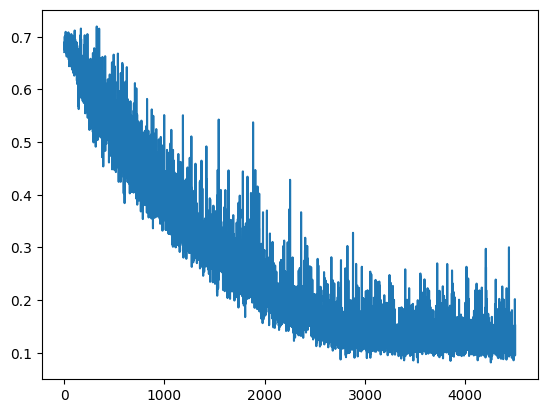

In [125]:
def learning_rate(iteration:int, total_iterations:int, lr=0.01, decay_after=0.8, decay_amount=0.1):
    return (lr * decay_amount) if iteration > (decay_after * total_iterations) else lr

def prepare_batch(X, Y, batch_size):
    idx = torch.randperm(X.shape[0])[:batch_size]
    return X[idx], Y[idx]

def train(model, X, Y, lr = 0.01, batch_size=24, num_iterations=4500):

    for layer in model.layers:
        layer.training = True

    losses = []
    loss = torch.nn.BCELoss()

    decay_after = 0.6 # decay after decay_after% iterations are done

    for i in range(0, num_iterations):

        # Batch data preparation
        batch_x, batch_y = prepare_batch(X, Y, batch_size)

        # Forward propagation:
        batch_y_pred = model(batch_x)
        lossi = loss(batch_y_pred, batch_y)

        # backward pass
        for p in model.parameters():
            p.grad = None
        lossi.backward()

        # update: simple SGD
        for p in model.parameters():
            p.data += -learning_rate(i, num_iterations, lr, decay_after) * p.grad

        if (i % 100 == 0) or (i == num_iterations - 1):
            print(f"Iteration {i+1} | Loss: {lossi.item()}")

        losses.append(lossi.item())

        # break

    return losses

losses = train(model, train_x_orig, train_y)
plt.plot(torch.tensor(losses))

train accuracy: 0.9952152967453003
test accuracy: 0.6200000047683716
[[14  3]
 [16 17]]


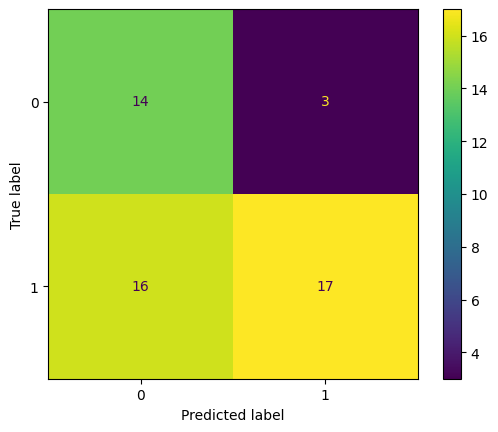

In [132]:
prediction_model = model

predictions_train = prediction_model.predict(train_x_orig)
train_accuracy = Model.accuracy(predictions_train, train_y)

predictions_test = prediction_model.predict(test_x_orig)
test_accuracy = Model.accuracy(predictions_test, test_y)

print(f"train accuracy: {train_accuracy}")
print(f"test accuracy: {test_accuracy}")

# Model.confustion_matrix(predictions_train, train_y)
Model.confustion_matrix(predictions_test, test_y)